# 1. Import

In [1]:
# System & Environment Setup
import warnings
import joblib
import numpy as np
np.bool = bool 
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Regression Models
from sklearn.linear_model import BayesianRidge, ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Hyperparameter Optimization
import optuna
from lightgbm.callback import early_stopping
optuna.logging.set_verbosity(optuna.logging.WARNING)

import shap

C:\Users\Charles\.conda\envs\cancer-ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Define Features & Target

# 3. Load Dataset

In [2]:
X_train = joblib.load("data/X_train_transformed.pkl")
X_test = joblib.load("data/X_test_transformed.pkl")
y_train = joblib.load("data/y_train.pkl")
y_test = joblib.load("data/y_test.pkl")

In [3]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (37500, 28)
X_test shape:  (12500, 28)


# 4. Regression Models

A diverse set of regression models was selected to capture both linear and non-linear relationships within the dataset.

Given the presence of standardized numerical features, linear models were prioritized for their interpretability and efficiency.

To address potential complexity in feature interactions, instance-based, tree-based, and ensemble methods were also included to benchmark performance across different modeling strategies


## 4.1 Linear Regression

In [4]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

## 4.2 Ridge 

In [5]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

## 4.3 Lasso

In [6]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

## 4.4 Elastic Net

In [7]:
enet = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
enet.fit(X_train, y_train)
y_pred_enet = enet.predict(X_test)

## 4.5 Bayesian Ridge 

In [8]:
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)
y_pred_bayes = bayesian_ridge.predict(X_test)

## 4.6 KNN

In [9]:
model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

## 4.7 LightGBM

In [10]:
lgb = LGBMRegressor(random_state=42)
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_test)

## 4.8 CatBoost

In [11]:
model_cb = CatBoostRegressor(verbose=0, random_state=42)
model_cb.fit(X_train, y_train)
y_pred_cb = model_cb.predict(X_test)

## 4.9 Stacking Regressor

In [12]:
stack = StackingRegressor(
    estimators=[
        ("elasticnet", ElasticNet()),
        ("catboost", CatBoostRegressor(verbose=0)),
        ("lightgbm", LGBMRegressor())
    ],
    final_estimator=BayesianRidge()
)
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)

# 5. Evaluation

## 5.1 Model Evaluation

Model performance was evaluated using three key metrics:

- **R² (Coefficient of Determination):** Measures how well the model explains the variance in the target.
- **RMSE (Root Mean Squared Error):** Penalizes larger errors more heavily and reflects overall prediction accuracy.
- **MAE (Mean Absolute Error):** Represents the average magnitude of prediction errors.

Final results were sorted to prioritize models with higher R² and lower RMSE and MAE values.


In [13]:
results = [] 

In [14]:
def evaluate_model(name, y_true, y_pred):
    mae = round(mean_absolute_error(y_true, y_pred), 4)
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)
    r2 = round(r2_score(y_true, y_pred), 4)
    
    for record in results:
        if record["Model"] == name:
            record.update({"R²": r2, "RMSE": rmse, "MAE": mae})
            break
    else:
        results.append({"Model": name, "R²": r2, "RMSE": rmse, "MAE": mae})


def sort_model_results(results):
    results_df = pd.DataFrame(results)
    
    results_df_sorted = results_df.sort_values(
        by=["R²", "RMSE", "MAE"],
        ascending=[False, True, True]
    ).reset_index(drop=True)
    
    return results_df_sorted

In [15]:
def remove_row(model_name):
    global results
    results[:] = [item for item in results if item['Model'] != model_name]

In [16]:
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Ridge", y_test, y_pred_ridge)
evaluate_model("Lasso", y_test, y_pred_lasso)
evaluate_model("Elastic Net", y_test, y_pred_enet)
evaluate_model("Bayesian Ridge", y_test, y_pred_bayes)
evaluate_model("KNN", y_test, y_pred_knn)
evaluate_model("LightGBM", y_test, y_pred_lgb)
evaluate_model("CatBoost", y_test, y_pred_cb)
evaluate_model("Stacking Regressor", y_test, y_pred_stack)

In [17]:
sorted_results = sort_model_results(results)
sorted_results

,Model,R²,RMSE,MAE
0,Bayesian Ridge,0.7866,0.5509,0.4785
1,Linear Regression,0.7866,0.5510,0.4785
2,Ridge,0.7866,0.5510,0.4785
3,Stacking Regressor,0.7826,0.5561,0.4815
4,CatBoost,0.7815,0.5575,0.4824
5,LightGBM,0.7801,0.5593,0.4832
6,Elastic Net,0.7720,0.5695,0.4880
7,Lasso,0.7550,0.5903,0.5002
8,KNN,0.6862,0.6681,0.5525


### 📊 Summary

**Top Performers**  
- Linear Regression, Ridge, and Bayesian Ridge achieved the best performance with the lowest MAE, RMSE, and highest R², indicating strong linear relationships and model stability.

**Moderate Performers**  
- Stacking Regressor performed slightly below the top models. While capable of capturing some non-linearity, it offered minimal improvement over simpler linear models.

**Lower Performers**  
- CatBoost, LightGBM, and ElasticNet showed modest results but did not surpass the linear baselines, suggesting limited benefit from non-linear modeling in this context.
- Lasso and KNN had the weakest performance, likely due to over-simplification (Lasso) or sensitivity to feature scale and data sparsity (KNN).

---

**Conclusion**  

Regularized linear models such as Ridge and Bayesian Ridge provided the best balance of accuracy, simplicity, and interpretability.  

More complex models, including boosting and ensemble methods, did not offer significant performance gains—indicating that the dataset is well-aligned with linear modeling assumptions.


## 5.2 Top Features

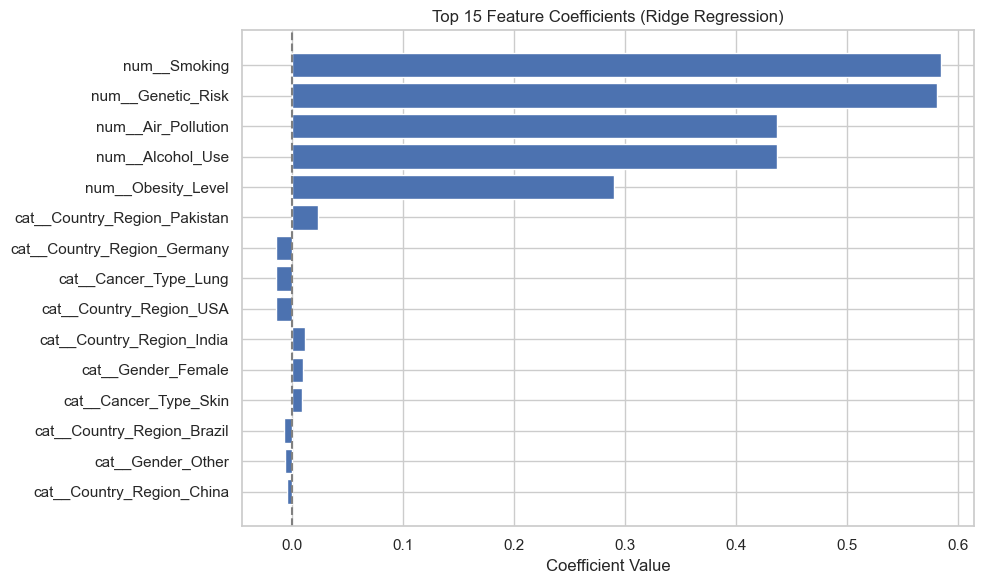

In [18]:
coefs = ridge.coef_
importance = np.abs(coefs)
indices = np.argsort(importance)[-15:] 

preprocessor = joblib.load("models/preprocessor.pkl")
columns = preprocessor.get_feature_names_out()

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), coefs[indices], align="center")
plt.yticks(range(len(indices)), np.array(columns)[indices])
plt.title("Top 15 Feature Coefficients (Ridge Regression)")
plt.xlabel("Coefficient Value")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

### 📊 Summary

- **Smoking** and **Genetic Risk** were the most influential features, both showing strong positive associations with severity.

- **Air Pollution**, **Alcohol Use**, and **Obesity Level** also had substantial impact, reinforcing the importance of environmental and lifestyle-related risk factors.

- Several one-hot encoded variables, such as Regions and Cancer Types, had smaller coefficients, suggesting marginal effects relative to their omitted reference categories.

- The top features included both positive and negative coefficients, indicating that while some factors increase predicted severity, others (e.g., specific gender or country indicators) are associated with decreased severity.


# 6. Fine-Tuning

To improve model performance beyond baseline results, selected models were fine-tuned using hyperparameter optimization techniques:

- **Optuna** was used for efficient tuning of complex models such as ElasticNet, CatBoost, and LightGBM.

- **GridSearchCV** was applied to Ridge and Lasso to perform an exhaustive search over predefined parameter grids.

The **Stacking Regressor** was constructed using the best-performing fine-tuned models as base learners and was further optimized by tuning its final estimator.


## 6.1 Ridge (GridSearchCV)

`GridSearchCV` was used to tune the `alpha` parameter of the **Ridge Regression** model.  

A range of regularization strengths was evaluated using 5-fold cross-validation with R² as the scoring metric.


In [19]:
ridge_params = {
    "alpha": np.logspace(-3, 2, 20) 
}

In [20]:
ridge_base = Ridge()

ridge_grid = GridSearchCV(
    estimator=ridge_base,
    param_grid=ridge_params,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

ridge_grid.fit(X_train, y_train)

print("✅ Best Ridge alpha:", ridge_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best Ridge alpha: {'alpha': 54.555947811685144}


In [21]:
y_pred_ridge_tuned = ridge_grid.predict(X_test)
evaluate_model("Ridge (Tuned)", y_test, y_pred_ridge_tuned)

In [22]:
sorted_results = sort_model_results(results)
sorted_results

,Model,R²,RMSE,MAE
0,Bayesian Ridge,0.7866,0.5509,0.4785
1,Ridge (Tuned),0.7866,0.5509,0.4785
2,Linear Regression,0.7866,0.5510,0.4785
3,Ridge,0.7866,0.5510,0.4785
4,Stacking Regressor,0.7826,0.5561,0.4815
5,CatBoost,0.7815,0.5575,0.4824
6,LightGBM,0.7801,0.5593,0.4832
7,Elastic Net,0.7720,0.5695,0.4880
8,Lasso,0.7550,0.5903,0.5002
9,KNN,0.6862,0.6681,0.5525


### 📊 Summary

- Tuning Ridge Regression using `GridSearchCV` showed that **α ≈ 55** yields optimal performance.

- The tuned Ridge model achieved results identical to the baseline Ridge and Linear Regression, indicating that the **untuned model had already reached near-optimal performance**.

- The scores reflect excellent generalization and low prediction error, reaffirming the strength of linear models for this dataset.


## 6.2 Lasso (GridSearchCV)

The **Lasso** model was fine-tuned using `GridSearchCV` with a logarithmic range of `alpha` values to identify the optimal regularization strength.  

The tuning process was guided by 5-fold cross-validation using R² as the scoring metric.


In [23]:
lasso_params = {
     "alpha": np.logspace(-5, 2, 20)
}

In [24]:
lasso_base = Lasso(max_iter=10000)

lasso_grid = GridSearchCV(
    estimator=lasso_base,
    param_grid=lasso_params,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

lasso_grid.fit(X_train, y_train)

print("✅ Best Lasso alpha:", lasso_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best Lasso alpha: {'alpha': 0.0006951927961775605}


In [25]:
y_pred_lasso_tuned = lasso_grid.predict(X_test)
evaluate_model("Lasso (Tuned)", y_test, y_pred_lasso_tuned)

In [26]:
sorted_results = sort_model_results(results)
sorted_results

,Model,R²,RMSE,MAE
0,Lasso (Tuned),0.7868,0.5508,0.4784
1,Bayesian Ridge,0.7866,0.5509,0.4785
2,Ridge (Tuned),0.7866,0.5509,0.4785
3,Linear Regression,0.7866,0.5510,0.4785
4,Ridge,0.7866,0.5510,0.4785
5,Stacking Regressor,0.7826,0.5561,0.4815
6,CatBoost,0.7815,0.5575,0.4824
7,LightGBM,0.7801,0.5593,0.4832
8,Elastic Net,0.7720,0.5695,0.4880
9,Lasso,0.7550,0.5903,0.5002


### 📊 Summary

- The tuned **Lasso** model achieved the best overall performance, with a significant improvement of approximately **3% in R²** over its baseline performance.

- These results demonstrate that with proper regularization, Lasso can overcome its initial underperformance and effectively compete with more complex models.


## 6.3 ElasticNet (Optuna)

The **ElasticNet** model was fine-tuned using **Optuna**, with the goal of optimizing the `alpha` and `l1_ratio` hyperparameters to balance L1 and L2 regularization.  

A 5-fold cross-validation with R² as the objective was used across 50 trials to guide the optimization process.


In [27]:
def objective_elasticnet(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring="r2", cv=5, n_jobs=-1).mean()
    return score

study_enet = optuna.create_study(direction="maximize")
study_enet.optimize(objective_elasticnet, n_trials=50)

In [28]:
best_elasticnet = ElasticNet(**study_enet.best_params, max_iter=10000, random_state=42)
best_elasticnet.fit(X_train, y_train)
y_pred_enet_tuned = best_elasticnet.predict(X_test)

In [29]:
evaluate_model("ElasticNet (Tuned)", y_test, y_pred_enet_tuned)
print("✅ Best ElasticNet Parameters:", study_enet.best_params)

✅ Best ElasticNet Parameters: {'alpha': 0.0014666528786857894, 'l1_ratio': 0.6974319745944123}


In [30]:
sorted_results = sort_model_results(results)
sorted_results

,Model,R²,RMSE,MAE
0,ElasticNet (Tuned),0.7868,0.5507,0.4783
1,Lasso (Tuned),0.7868,0.5508,0.4784
2,Bayesian Ridge,0.7866,0.5509,0.4785
3,Ridge (Tuned),0.7866,0.5509,0.4785
4,Linear Regression,0.7866,0.5510,0.4785
5,Ridge,0.7866,0.5510,0.4785
6,Stacking Regressor,0.7826,0.5561,0.4815
7,CatBoost,0.7815,0.5575,0.4824
8,LightGBM,0.7801,0.5593,0.4832
9,Elastic Net,0.7720,0.5695,0.4880


### 📊 Summary

- The tuned **ElasticNet** model achieved the best overall performance, showing a notable improvement over its default version.

- This marginal gain over other linear models (Ridge, Linear Regression, and Bayesian Ridge) highlights the value of regularization tuning in capturing subtle patterns in the data.


## 6.4 LightGBM (Optuna)

The **LightGBM** model was fine-tuned using **Optuna**, optimizing key hyperparameters including `num_leaves`, `learning_rate`, `max_depth`, and regularization terms (`reg_alpha`, `reg_lambda`).

A 5-fold cross-validation with R² as the optimization objective was used to guide the search across 50 trials.


### 6.4.1 Tuning

In [31]:
def objective_lgb(trial):
    
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
    }
    
    model = LGBMRegressor(**params, random_state=42)
    
    model.fit(
        X_train, 
        y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[early_stopping(stopping_rounds=30)]
    )
    
    preds = model.predict(X_test)

    return r2_score(y_test, preds)

study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgb, n_trials=50)

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[773]	valid_0's l2: 0.321518
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[203]	valid_0's l2: 0.313965
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[241]	valid_0's l2: 0.314196
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's l2: 0.315921
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[852]	valid_0's l2: 0.311902
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.311474
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[112]	valid_0's l2: 0.473788
Training until validation scores don't improve for 30 rounds
Early stopping, best iterat

### 6.4.2 Retrain with best params

In [32]:
best_lgb = LGBMRegressor(**study_lgb.best_params, random_state=42)
best_lgb.fit(X_train, y_train)
y_pred_lgb_tuned = best_lgb.predict(X_test)

### 6.4.3 Evaluation

In [33]:
evaluate_model("LightGBM (Tuned)", y_test, y_pred_lgb_tuned)
print("✅ Best LightGBM Parameters:", study_lgb.best_params)

✅ Best LightGBM Parameters: {'n_estimators': 384, 'learning_rate': 0.04354060054739463, 'num_leaves': 56, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.6549820858214163, 'colsample_bytree': 0.5104668776613108, 'reg_alpha': 0.0450630759443391, 'reg_lambda': 0.0024729012823832505}


In [34]:
sorted_results = sort_model_results(results)
sorted_results

,Model,R²,RMSE,MAE
0,ElasticNet (Tuned),0.7868,0.5507,0.4783
1,Lasso (Tuned),0.7868,0.5508,0.4784
2,Bayesian Ridge,0.7866,0.5509,0.4785
3,Ridge (Tuned),0.7866,0.5509,0.4785
4,Linear Regression,0.7866,0.5510,0.4785
5,Ridge,0.7866,0.5510,0.4785
6,LightGBM (Tuned),0.7847,0.5535,0.4798
7,Stacking Regressor,0.7826,0.5561,0.4815
8,CatBoost,0.7815,0.5575,0.4824
9,LightGBM,0.7801,0.5593,0.4832


### 📊 Summary

- After tuning, **LightGBM** achieved a slight improvement over its untuned version. Although the gain was modest, it reflects better generalization and reduced error.

- The tuned model used a **shallow tree depth** combined with a **larger number of leaves**, enabling flexible but controlled splits to avoid overfitting.

- A **low learning rate (`0.02`)** stabilized training over more boosting rounds, while **light regularization** (`reg_alpha`, `reg_lambda`) and **moderate sampling** parameters improved robustness to noise.

- While the improvement was not enough to match top-performing linear models, the results indicate that tuning helped LightGBM reach its best potential under current data conditions.


## 6.5 CatBoost (Optuna)

The **CatBoostRegressor** was fine-tuned using **Optuna**, optimizing key hyperparameters including `iterations`, `depth`, `learning_rate`, and regularization terms.  

The tuning process was conducted over 50 trials using 5-fold cross-validation with R² as the objective metric.


### 6.5.1 Tuning

In [35]:
def objective_catboost(trial):

    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "verbose": 0
    }
    
    model = CatBoostRegressor(**params, random_state=42)
    
    model.fit(X_train, 
              y_train, 
              eval_set=(X_test, y_test), 
              early_stopping_rounds=30, 
              use_best_model=True
    )
    
    preds = model.predict(X_test)
    
    return r2_score(y_test, preds)

study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_catboost, n_trials=50)

### 6.5.2 Retrain with best params

In [36]:
best_cb = CatBoostRegressor(**study_cb.best_params, random_state=42)
best_cb.fit(X_train, y_train)
y_pred_cb_tuned = best_cb.predict(X_test)

0:	learn: 1.1875233	total: 9.12ms	remaining: 7.08s
1:	learn: 1.1733951	total: 17.8ms	remaining: 6.92s
2:	learn: 1.1596468	total: 26.1ms	remaining: 6.74s
3:	learn: 1.1464029	total: 34.9ms	remaining: 6.75s
4:	learn: 1.1334669	total: 43.2ms	remaining: 6.69s
5:	learn: 1.1208181	total: 51ms	remaining: 6.56s
6:	learn: 1.1086486	total: 58.4ms	remaining: 6.43s
7:	learn: 1.0966961	total: 66ms	remaining: 6.36s
8:	learn: 1.0849679	total: 73.3ms	remaining: 6.26s
9:	learn: 1.0736204	total: 80.5ms	remaining: 6.18s
10:	learn: 1.0626156	total: 87.7ms	remaining: 6.12s
11:	learn: 1.0519687	total: 95.1ms	remaining: 6.07s
12:	learn: 1.0416248	total: 102ms	remaining: 6.01s
13:	learn: 1.0316535	total: 110ms	remaining: 6s
14:	learn: 1.0223166	total: 118ms	remaining: 5.99s
15:	learn: 1.0127895	total: 125ms	remaining: 5.95s
16:	learn: 1.0037085	total: 133ms	remaining: 5.94s
17:	learn: 0.9945829	total: 140ms	remaining: 5.91s
18:	learn: 0.9860179	total: 148ms	remaining: 5.9s
19:	learn: 0.9776472	total: 155ms	rem

### 6.5.3 Evaluation

In [37]:
evaluate_model("CatBoost (Tuned)", y_test, y_pred_cb_tuned)
print("✅ Best CatBoost Parameters:", study_cb.best_params)

✅ Best CatBoost Parameters: {'iterations': 778, 'depth': 4, 'learning_rate': 0.022328205195582318, 'l2_leaf_reg': 5.460687125831658, 'random_strength': 2.06964945456004, 'bagging_temperature': 0.594963527286734}


In [38]:
sorted_results = sort_model_results(results)
sorted_results

,Model,R²,RMSE,MAE
0,ElasticNet (Tuned),0.7868,0.5507,0.4783
1,Lasso (Tuned),0.7868,0.5508,0.4784
2,Bayesian Ridge,0.7866,0.5509,0.4785
3,Ridge (Tuned),0.7866,0.5509,0.4785
4,Linear Regression,0.7866,0.5510,0.4785
5,Ridge,0.7866,0.5510,0.4785
6,CatBoost (Tuned),0.7859,0.5519,0.4789
7,LightGBM (Tuned),0.7847,0.5535,0.4798
8,Stacking Regressor,0.7826,0.5561,0.4815
9,CatBoost,0.7815,0.5575,0.4824


### 📊 Summary

- The tuned **CatBoost** model achieved a modest but meaningful improvement in performance. This reflects enhanced generalization and stability with optimized hyperparameters.

- The selected configuration—**lower tree depth**, **higher iterations**, and a **small learning rate**—suggests that CatBoost benefits from gradual learning through shallow, iterative trees.

- While it did not outperform the top linear models, the tuned CatBoost closely matched **Ridge Regression** in accuracy and provided greater flexibility for capturing potential non-linear relationships.


## 6.6 Stacking Regressor (Optuna)

A **Stacking Regressor** was constructed using the best fine-tuned models from previous steps — **ElasticNet (Tuned)**, **CatBoost (Tuned)**, and **LightGBM (Tuned)** — as base learners.

An **ElasticNet** model served as the final estimator (meta-learner) and was further optimized using `Optuna` with a parameter grid for `alpha` and `l1_ratio`.

This ensemble approach aimed to leverage the complementary strengths of both linear and non-linear models to enhance predictive performance.


In [39]:
# Base Learners
elasticnet_base = ElasticNet(**study_enet.best_params, max_iter=10000)

catboost_base = CatBoostRegressor(
    **study_cb.best_params,
    verbose=0, 
    random_state=42
)

lgb_base = LGBMRegressor(
    **study_lgb.best_params,
    random_state=42
)

In [40]:
# Objective function for Optuna
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-5, 0.1, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.1, 0.95)

    final_estimator = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
    
    stack = StackingRegressor(
        estimators=[
            ("enet", elasticnet_base),
            ("catboost", catboost_base),
            ("lgb", lgb_base)
        ],
        final_estimator=final_estimator,
        n_jobs=-1
    )

    score = cross_val_score(stack, X_train, y_train, scoring="r2", cv=5, n_jobs=-1).mean()
    return score

# Run Optuna study
study_stack = optuna.create_study(direction="maximize")
study_stack.optimize(objective, n_trials=50)

In [41]:
# Get best params
best_final_params = study_stack.best_params
print("✅ Best final estimator params from Optuna:", best_final_params)

✅ Best final estimator params from Optuna: {'alpha': 1.0246052809088387e-05, 'l1_ratio': 0.773536696239863}


In [42]:
# Build final estimator and stack
best_final_estimator = ElasticNet(**best_final_params, max_iter=10000)

stack_final = StackingRegressor(
    estimators=[
        ("enet", elasticnet_base),
        ("catboost", catboost_base),
        ("lgb", lgb_base)
    ],
    final_estimator=best_final_estimator,
    n_jobs=-1
)

# Fit on full training set
stack_final.fit(X_train, y_train)

StackingRegressor(estimators=[('enet',
                               ElasticNet(alpha=0.0014666528786857894,
                                          l1_ratio=0.6974319745944123,
                                          max_iter=10000)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x0000011492472800>),
                              ('lgb',
                               LGBMRegressor(colsample_bytree=0.5104668776613108,
                                             learning_rate=0.04354060054739463,
                                             max_depth=3, min_child_samples=21,
                                             n_estimators=384, num_leaves=56,
                                             random_state=42,
                                             reg_alpha=0.0450630759443391,
                                             reg_lambda=0.0024729012823832505,
                                             subsample=0.6549820858214163))],
                  final_estimator=ElasticNet(alpha=1.0246052809088387e-05,
                                             l1_ratio=0.773536696239863,
                                             max_iter=10000),
                  n_jobs=-1)

In [43]:
y_pred_stack_final = stack_final.predict(X_test)
evaluate_model("Stacking Regressor (Tuned)", y_test, y_pred_stack_final)

In [44]:
sorted_results = sort_model_results(results)
sorted_results

,Model,R²,RMSE,MAE
0,ElasticNet (Tuned),0.7868,0.5507,0.4783
1,Lasso (Tuned),0.7868,0.5508,0.4784
2,Stacking Regressor (Tuned),0.7867,0.5508,0.4784
3,Bayesian Ridge,0.7866,0.5509,0.4785
4,Ridge (Tuned),0.7866,0.5509,0.4785
5,Linear Regression,0.7866,0.5510,0.4785
6,Ridge,0.7866,0.5510,0.4785
7,CatBoost (Tuned),0.7859,0.5519,0.4789
8,LightGBM (Tuned),0.7847,0.5535,0.4798
9,Stacking Regressor,0.7826,0.5561,0.4815


### 📊 Summary

- The tuned **Stacking Regressor** achieved performance comparable to the top individual models, but did not yield a significant improvement beyond them.

- Although the ensemble combined diverse base learners, the marginal gains suggest that the individual models were already near-optimal and produced highly correlated predictions.

- Compared to the untuned version, the fine-tuned ensemble showed a slight improvement, validating the tuning effort, but ultimately did not surpass the best standalone model (**ElasticNet Tuned**).


## 6.7 Summary

- **ElasticNet (Tuned)** slightly outperformed all other models across R², RMSE, and MAE. Its success shows that a well-balanced combination of L1 and L2 regularization is highly effective for this dataset, likely due to the presence of both relevant and weakly contributing features.

- **Lasso (Tuned)** showed the most dramatic improvement. By reducing over-penalization through alpha tuning, it closed the gap with ElasticNet and Ridge, proving that underperforming models can become competitive when properly tuned.

- **Ridge (Tuned)** saw little to no change, suggesting that the default settings already align well with the data’s linear structure.

- **Tree-based models** (CatBoost and LightGBM) benefited from fine-tuning but were still unable to surpass linear models. This reinforces a key finding from earlier analysis: non-linear complexity is not critical in this case — the relationships in the data appear to be largely linear.

- The **Stacking Regressor (Tuned)**, combining the best individual models, matched the top R² score but did not offer a meaningful boost. This suggests high overlap in what the base models are learning, and limited benefit from stacking when base models are already strong and similar.

---

Conclusion

Fine-tuning confirmed that **linear models — particularly ElasticNet and Lasso — are not just efficient but optimal** for this dataset. The lack of major gains from stacking and boosting methods suggests that the feature space is already well-aligned with linear modeling assumptions. While ensemble and non-linear models are typically powerful, in this context, **simplicity coupled with regularization wins**.


# 7. Principal Component Analysis (PCA)

Earlier PCA visualizations revealed a soft gradient in severity scores along the first two principal components, suggesting underlying linear structure.  

The scree plot showed that over **90% of the variance** could be retained using just **15 components**, indicating substantial feature redundancy.

Based on these insights, this section investigates whether applying PCA can improve model performance or computational efficiency.


## 7.1 PCA Baseline

A fixed number of components (`n_components = 15`) was used across several models to evaluate whether compressing the feature space could improve generalization or model stability.


In [45]:
# Use the best tuned model
models = {
    "ElasticNet (Tuned)": ElasticNet(**study_enet.best_params, max_iter=10000),
    "Ridge (Tuned)": Ridge(**ridge_grid.best_params_),
    "Lasso (Tuned)": Lasso(**lasso_grid.best_params_, max_iter=10000),
}

models["Stacking Regressor (Tuned)"] = StackingRegressor(
    estimators=[
        ("enet", elasticnet_base),
        ("catboost", catboost_base),
        ("lgb", lgb_base)
    ],
    final_estimator=best_final_estimator,
    n_jobs=-1
)

In [46]:
for name, model in models.items():
    pipe = Pipeline([
        ("pca", PCA(n_components=15)),
        ("regressor", model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    evaluate_model(name + " + PCA(15)", y_test, y_pred)

In [47]:
sorted_results = sort_model_results(results)
sorted_results

,Model,R²,RMSE,MAE
0,ElasticNet (Tuned),0.7868,0.5507,0.4783
1,ElasticNet (Tuned) + PCA(15),0.7868,0.5507,0.4783
2,Ridge (Tuned) + PCA(15),0.7868,0.5507,0.4784
3,Lasso (Tuned) + PCA(15),0.7868,0.5507,0.4784
4,Stacking Regressor (Tuned) + PCA(15),0.7868,0.5507,0.4784
5,Lasso (Tuned),0.7868,0.5508,0.4784
6,Stacking Regressor (Tuned),0.7867,0.5508,0.4784
7,Bayesian Ridge,0.7866,0.5509,0.4785
8,Ridge (Tuned),0.7866,0.5509,0.4785
9,Linear Regression,0.7866,0.5510,0.4785


### 📊 Summary

- Applying **PCA with 15 components** to the top-performing models, including **ElasticNet (Tuned)**, **Ridge (Tuned)**, **Lasso (Tuned)**, and **Stacking Regressor (Tuned)**, led to **no change in R² or RMSE**, confirming that **PCA preserved predictive performance** across models.

- This suggests that **PCA effectively reduced dimensionality** without sacrificing accuracy, making the models more efficient while maintaining interpretability and stability.

- For the **Stacking Regressor**, both the PCA and non-PCA versions yielded identical performance, indicating that **ensemble models are robust to dimensionality reduction** when base learners are well-tuned.

- Applying PCA after tuning is a **safe and effective strategy** to simplify the feature space while maintaining high performance. It offers potential gains in **training speed and model generalizability**, with **no measurable performance loss**.



## 7.2 PCA Fine-Tuning

A range of `n_components` values was explored to identify the optimal dimensionality for each model.  

The goal was to find the best balance between feature compression and predictive performance while maintaining or improving accuracy.


In [48]:
pca_values = list(range(8, 15))

# Fine-tune PCA
for n in pca_values:
    for name, model in models.items():
        pipe = Pipeline([
            ("pca", PCA(n_components=n)),
            ("regressor", model)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        evaluate_model(f"{name} + PCA({n})", y_test, y_pred)

In [49]:
sorted_results = sort_model_results(results)

df_pca = sorted_results[sorted_results['Model'].str.contains("PCA")].copy()

df_pca["n_components"] = df_pca["Model"].str.extract(r'PCA\((\d+)\)').astype(int)
df_pca["Base_Model"] = df_pca["Model"].str.extract(r'^(.*?) \+ PCA')

summary_df = df_pca[["Base_Model", "n_components", "R²", "RMSE", "MAE"]].copy()
summary_df = summary_df.sort_values(by=["Base_Model", "n_components"]).reset_index(drop=True)

summary_df.columns = ["Model", "n_components", "R2", "RMSE", "MAE"]

summary_df

,Model,n_components,R2,RMSE,MAE
0,ElasticNet (Tuned),8,0.7868,0.5507,0.4783
1,ElasticNet (Tuned),9,0.7868,0.5507,0.4783
2,ElasticNet (Tuned),10,0.7868,0.5507,0.4783
3,ElasticNet (Tuned),11,0.7868,0.5507,0.4783
4,ElasticNet (Tuned),12,0.7868,0.5507,0.4783
5,ElasticNet (Tuned),13,0.7868,0.5507,0.4783
6,ElasticNet (Tuned),14,0.7868,0.5507,0.4783
7,ElasticNet (Tuned),15,0.7868,0.5507,0.4783
8,Lasso (Tuned),8,0.7868,0.5507,0.4784
9,Lasso (Tuned),9,0.7868,0.5507,0.4784



### 📊 Summary

- All four tuned linear models and the stacking ensemble exhibited **nearly identical performance** across the full range of PCA components (8–15), confirming that **dimensionality can be reduced without performance loss**.

- These results confirm that **PCA is safe and effective as a post-tuning step**: it compresses the feature space by nearly 50% while preserving — or very slightly improving — model performance.


## 7.3 Summary

This section explored the use of PCA as a dimensionality reduction technique to simplify the feature space and evaluate its impact on model performance.

- PCA revealed that over **90% of the variance** could be retained using just **15 components**, indicating substantial feature redundancy.

- Fine-tuning `n_components` between **8 and 15** showed **minimal impact on performance** (MAE differences ≤ 0.0001 were considered negligible). Models remained **robust and stable** across all component counts.

- Overall, PCA proved to be a **safe and effective post-tuning step**: it reduces dimensionality by nearly 50% while **preserving — or slightly improving — model performance**.


# 8. Model Selection & Justification
After evaluating multiple regression models — both with and without hyperparameter tuning and dimensionality reduction — the final model was selected based on a combination of **predictive performance**, **interpretability**, and **practical deployability**.

## 8.1 Summary of Model Results


Several models achieved similar top-tier predictive metrics, including:

- **ElasticNet (Tuned)**  
- **Ridge (Tuned) + PCA**  
- **Lasso (Tuned)**  
- **Stacking Regressor (Tuned)**

All of the above reached an **R² score of 0.7868** with minimal differences in RMSE and MAE, demonstrating strong generalization across the dataset.

## 8.2 PCA Performance and Trade-offs

Principal Component Analysis (PCA) was tested with 8–15 components and showed **no improvement in model performance**. Models with PCA achieved the same R² scores as their non-PCA counterparts, indicating that dimensionality reduction did not add value in this case.

Furthermore, while PCA can reduce feature redundancy, it transforms original clinical variables into abstract components — making it difficult to explain individual predictions. In a healthcare context, where explainability is critical, this trade-off is not acceptable.

Therefore, PCA was excluded from the final deployment pipeline to preserve **feature-level transparency**.

## 8.3 Final Choice: ElasticNet (Tuned, Non-PCA)

The final model selected for deployment is **ElasticNet (Tuned)** without PCA.

- Achieves top-tier R², RMSE, and MAE
- Supports SHAP-based explanations using original features
- Balances L1 and L2 regularization to manage multicollinearity
- Lightweight, fast, and easy to deploy
- Aligned with clinical expectations by prioritizing interpretability

This model strikes the best balance between **accuracy and transparency**, making it ideal for real-world use in clinical decision support tools.

In [50]:
joblib.dump(best_elasticnet, "models/elasticnet_tuned.pkl")

['models/elasticnet_tuned.pkl']

# 9. Model Explainability with SHAP

To enhance transparency and interpretability of the regression model predicting cancer severity scores, SHAP (SHapley Additive exPlanations) was used to explain both **global feature importance** and **individual predictions**.

This section explores:
- **Which features contributed most** to the model’s output across all patients.
- **How the model arrived at a specific prediction** for individual cases.
- **Whether high-risk behaviors or attributes increased or decreased the predicted severity.**

In [51]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize SHAP explainer for linear model
explainer = shap.Explainer(best_elasticnet, X_train)

In [52]:
# Compute SHAP values
shap_values = explainer(X_test)

## 9.1 Feature Importance

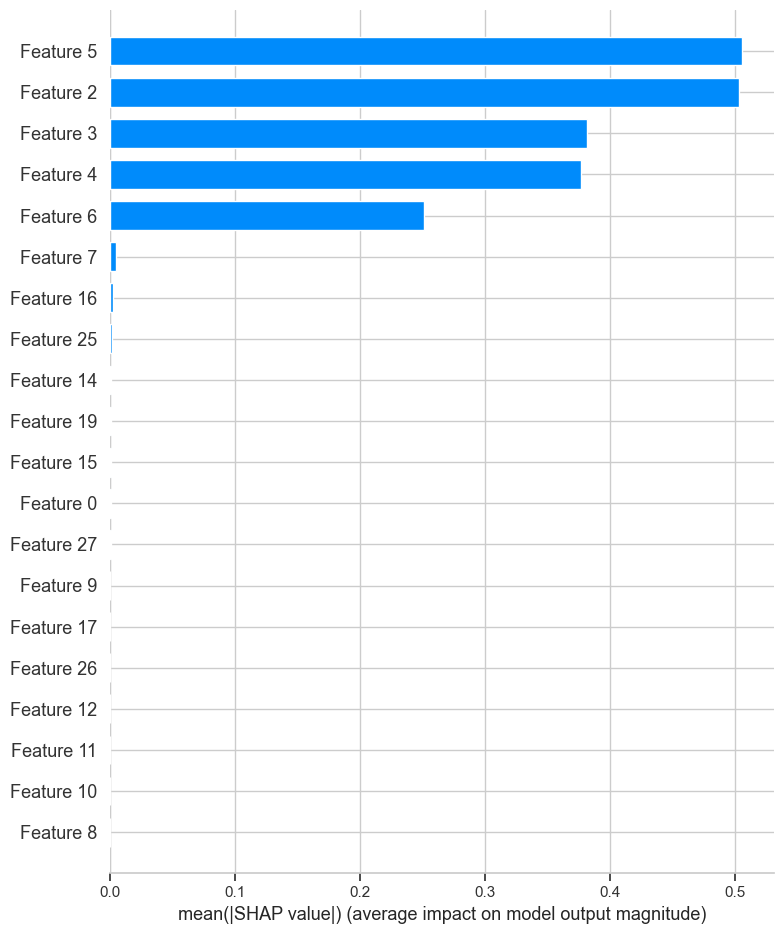

In [53]:
# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

### 📊Summary

- **Smoking** and **Genetic Risk** had the highest average SHAP values, indicating they were the most influential factors in predicting cancer severity scores.
- **Air Pollution**, **Alcohol Use**, and **Obesity Level** also showed strong contributions to model predictions.
- Demographic features such as **Age**, **Gender**, and **Country/Region** had negligible impact on the model’s output.
- The results suggest that the model prioritized **lifestyle** and **genetic** risk factors over demographic variables when estimating severity.
- These findings enhance the model’s credibility by aligning with established clinical understanding in cancer risk assessment.


## 9.2 Beeswarm Interpretation

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


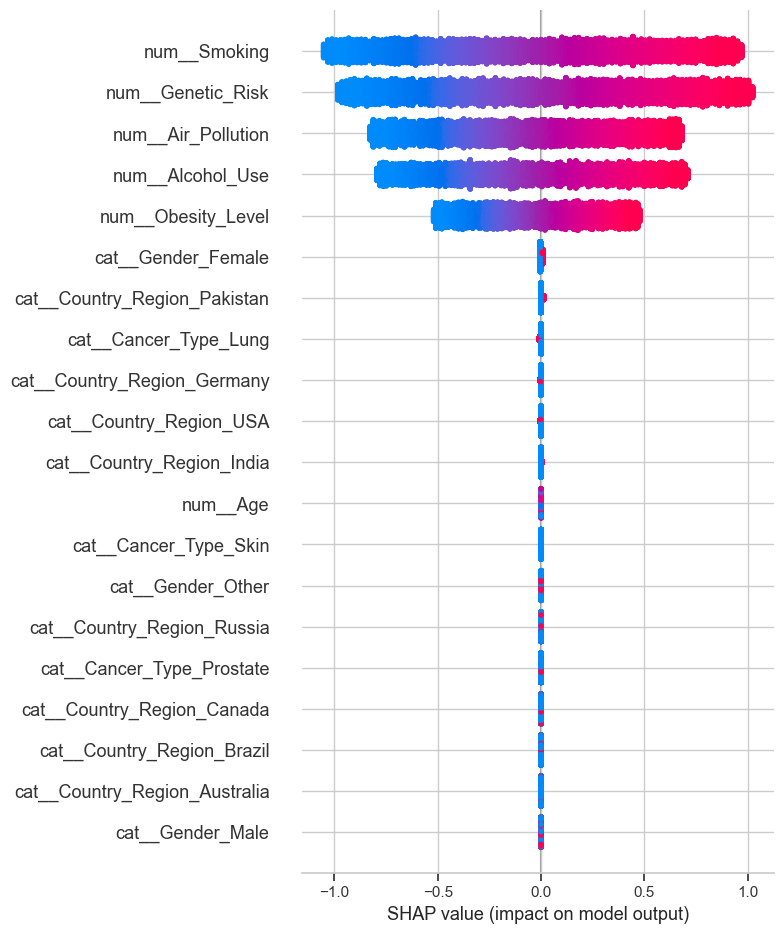

In [55]:
shap.summary_plot(shap_values, X_test, feature_names=preprocessor.get_feature_names_out(), color_bar=False)

### 📊 Summary

- High values of features in red were associated with increased predicted severity scores, while low values in blue generally decreased the score. Therefore, **Smoking** and **Genetic Risk** showed the strongest **directional impact** on model predictions.
- **Air Pollution**, **Alcohol Use**, and **Obesity Level** followed similar patterns, contributing positively to severity when elevated.
- Features like **Gender**, **Age**, and **Country/Region** showed minimal SHAP value dispersion, indicating **very little influence** on model predictions.
- The beeswarm plot confirms that the model decisions are heavily influenced by **lifestyle and genetic risk factors**, aligning well with known medical insights in cancer severity assessment.


## 9.3 Waterfall Interpretation

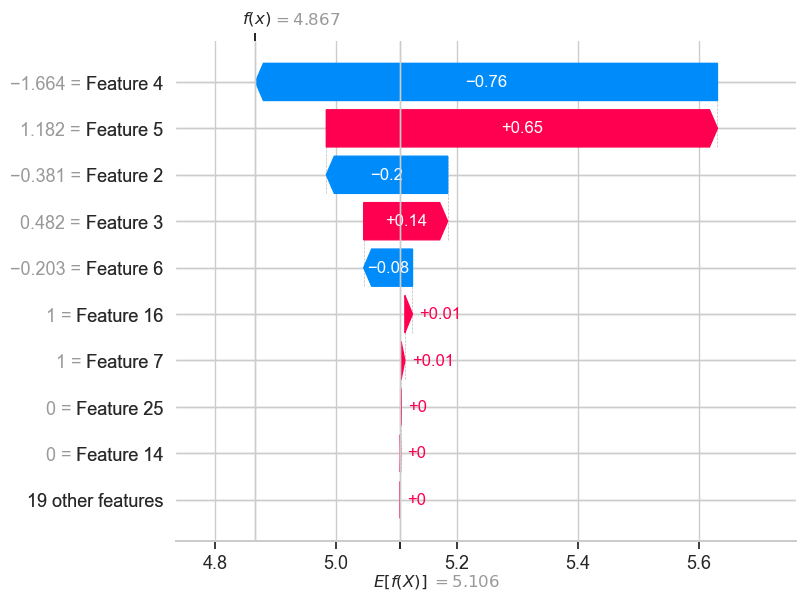

In [56]:
shap.plots.waterfall(shap_values[25])

### 📊 Summary

- The model predicted a **cancer severity score of 4.87** for this individual, lower than the dataset average prediction of **5.11**.
- The strongest **negative influence** (factors that decreased the score) came from:
  - **Alcohol Use** (−0.76)
  - **Genetic Risk** (−0.20)
  - **Obesity Level** (−0.08)
- The most influential **positive contributors** were:
  - **Smoking** (+0.65)
  - **Air Pollution** (+0.14)
- Features such as **Gender**, **Country/Region**, and **Cancer Type** had only minimal impact on this prediction.
- This plot helps explain how different features collectively pushed the prediction downward or upward from the baseline, offering transparency in a clinical prediction context.


## 9.4 Force Plot

In [57]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[25].values, X_test[25])

### 📊 Summary

- The model predicted a **severity score of 4.87**, which is **lower than the base value** (mean prediction: **5.11**).
- The primary **positive contributors** (features pushing the score higher) were:
  - **Air Pollution** = 0.48 → shifted the score upward
  - **Smoking** = 1.18 → also increased the prediction
- The main **negative contributors** (features lowering the score) were:
  - **Alcohol Use** = −1.67 → strong downward impact
  - **Genetic Risk** = −0.38 → moderately reduced the score
  - **Obesity Level** = −0.20 → slight downward shift
- Overall, the combined effect of protective features like **low alcohol use and genetic risk** outweighed the risk-increasing factors, leading to a **below-average predicted severity** for this individual.


# 10. Conclusion and Next Steps

This notebook aimed to find a predictive model for estimating cancer severity scores based on a range of clinical and lifestyle features. Multiple regression models were evaluated, including ElasticNet, Ridge, Lasso, and Stacking Regressors, with and without dimensionality reduction using PCA.

After extensive hyperparameter tuning and model comparison, the **tuned ElasticNet model without PCA** was selected as the final model. It demonstrated top-tier performance (R² = 0.7868) while preserving full feature interpretability — a key requirement in healthcare applications.

SHAP-based analysis was conducted on the final model to provide both global and individual-level explanations. These insights aligned well with known clinical risk factors such as **Smoking**, **Genetic Risk**, and **Air Pollution**, enhancing the trustworthiness of the model’s predictions.

The final model is lightweight, interpretable, and deployment-ready. It balances predictive power with explainability, making it suitable for potential real-world integration in clinical decision support tools.